# pyiron

## Define workflow with pyiron_base

In [1]:
import numpy as np
from pyiron_base import job
from python_workflow_definition.pyiron_base import write_workflow_json

In [2]:
from workflow import (
    calculate_qe as _calculate_qe, 
    generate_structures as _generate_structures, 
    get_bulk_structure as _get_bulk_structure, 
    plot_energy_volume_curve as _plot_energy_volume_curve,
)

In [3]:
workflow_json_filename = "pyiron_base_qe.json"

In [4]:
calculate_qe = job(_calculate_qe, output_key_lst=["energy", "volume", "structure"])
generate_structures = job(_generate_structures)
plot_energy_volume_curve = job(_plot_energy_volume_curve)
get_bulk_structure = job(_get_bulk_structure)

In [5]:
pseudopotentials = {"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"}

In [6]:
structure = get_bulk_structure(
    element="Al",
    a=4.04,
    cubic=True,
)

In [7]:
calc_mini = calculate_qe(
    working_directory="mini",
    input_dict={
        "structure": structure,
        "pseudopotentials": pseudopotentials,
        "kpts": (3, 3, 3),
        "calculation": "vc-relax",
        "smearing": 0.02,
    },
)

In [8]:
number_of_strains = 5
structure_lst = generate_structures(  # the generate_structures() function is not available in the workflow graph
    structure=calc_mini.output.structure,
    strain_lst=np.linspace(0.9, 1.1, number_of_strains),
    list_length=number_of_strains,
)

In [9]:
job_strain_lst = []
for i, structure_strain in enumerate(structure_lst):
    calc_strain = calculate_qe(
        working_directory="strain_" + str(i),
        input_dict={
            "structure": structure_strain,
            "pseudopotentials": pseudopotentials,
            "kpts": (3, 3, 3),
            "calculation": "scf",
            "smearing": 0.02,
        },
    )
    job_strain_lst.append(calc_strain)

In [10]:
plot = plot_energy_volume_curve(
    volume_lst=[job.output.volume for job in job_strain_lst],
    energy_lst=[job.output.energy for job in job_strain_lst],
)

In [11]:
write_workflow_json(delayed_object=plot, file_name=workflow_json_filename)

In [12]:
!cat {workflow_json_filename}

{
  "version": "0.1.0",
  "nodes": [
    {
      "id": 0,
      "type": "function",
      "value": "workflow.plot_energy_volume_curve"
    },
    {
      "id": 1,
      "type": "function",
      "value": "python_workflow_definition.shared.get_list"
    },
    {
      "id": 2,
      "type": "function",
      "value": "workflow.calculate_qe"
    },
    {
      "id": 3,
      "type": "function",
      "value": "python_workflow_definition.shared.get_dict"
    },
    {
      "id": 4,
      "type": "function",
      "value": "workflow.generate_structures"
    },
    {
      "id": 5,
      "type": "function",
      "value": "workflow.calculate_qe"
    },
    {
      "id": 6,
      "type": "function",
      "value": "python_workflow_definition.shared.get_dict"
    },
    {
      "id": 7,
      "type": "function",
      "value": "workflow.get_bulk_structure"
    },
    {
      "id": 8,
      "type": "function",
      "value": "workflow.calculate_qe"
    },
    {
      "id": 9,
      "type": "fu

## Load Workflow with aiida

In [13]:
from aiida import orm, load_profile

load_profile()

Profile<uuid='3ce302a995914d2e8a7b6327a10fe381' name='pwd'>

In [14]:
from python_workflow_definition.aiida import load_workflow_json

In [15]:
wg = load_workflow_json(file_name=workflow_json_filename)

In [16]:
wg.nodes.get_bulk_structure8.inputs.a.value = orm.Float(4.05)

05/24/2025 06:00:13 AM <10378> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [249|WorkGraphEngine|continue_workgraph]: tasks ready to run: get_bulk_structure8
05/24/2025 06:00:13 AM <10378> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [249|WorkGraphEngine|update_task_state]: Task: get_bulk_structure8, type: PyFunction, finished.
05/24/2025 06:00:13 AM <10378> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [249|WorkGraphEngine|continue_workgraph]: tasks ready to run: get_dict7
05/24/2025 06:00:14 AM <10378> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [249|WorkGraphEngine|update_task_state]: Task: get_dict7, type: PyFunction, finished.
05/24/2025 06:00:14 AM <10378> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [249|WorkGraphEngine|continue_workgraph]: tasks ready to run: calculate_qe6
[jupyter-pythonworkflow-fl--x---d7231032:10471] mca_base_component_repository_open: unable to open

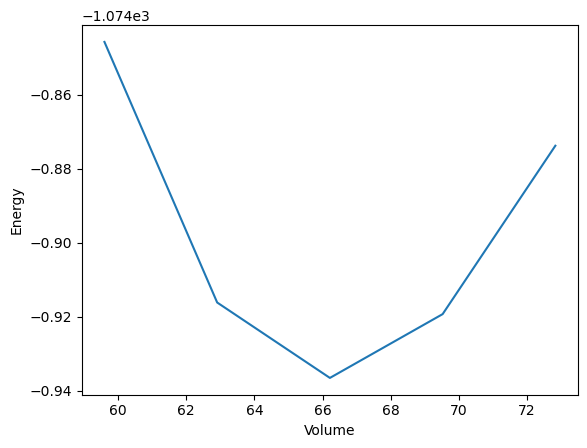

In [17]:
wg.run()

## Load Workflow with jobflow

In [18]:
from python_workflow_definition.jobflow import load_workflow_json

In [19]:
from jobflow.managers.local import run_locally

In [20]:
flow = load_workflow_json(file_name=workflow_json_filename)

In [21]:
flow[0].function_kwargs["a"] = 4.05

2025-05-24 06:02:16,526 INFO Started executing jobs locally
2025-05-24 06:02:16,619 INFO Starting job - get_bulk_structure (49008d34-c2c0-41a9-a7cb-17f68fd503d3)
2025-05-24 06:02:16,622 INFO Finished job - get_bulk_structure (49008d34-c2c0-41a9-a7cb-17f68fd503d3)
2025-05-24 06:02:16,623 INFO Starting job - get_dict (f81de048-62e5-448c-9783-fc9cb4d4bb7d)
2025-05-24 06:02:16,625 INFO Finished job - get_dict (f81de048-62e5-448c-9783-fc9cb4d4bb7d)
2025-05-24 06:02:16,625 INFO Starting job - calculate_qe (e7891e79-cd64-4e19-b474-4e5c4521807b)


[jupyter-pythonworkflow-fl--x---d7231032:10547] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-05-24 06:03:08,574 INFO Finished job - calculate_qe (e7891e79-cd64-4e19-b474-4e5c4521807b)
2025-05-24 06:03:08,576 INFO Starting job - generate_structures (05513874-a1a3-428c-91ad-7ba4f44d13c4)
2025-05-24 06:03:08,580 INFO Finished job - generate_structures (05513874-a1a3-428c-91ad-7ba4f44d13c4)
2025-05-24 06:03:08,580 INFO Starting job - get_dict (4b033be6-d0c6-4bc4-8f10-eb0ff6ad94f8)
2025-05-24 06:03:08,582 INFO Finished job - get_dict (4b033be6-d0c6-4bc4-8f10-eb0ff6ad94f8)
2025-05-24 06:03:08,583 INFO Starting job - get_dict (8fb5c055-10cd-4cf0-adcc-57703638e0c8)
2025-05-24 06:03:08,584 INFO Finished job - get_dict (8fb5c055-10cd-4cf0-adcc-57703638e0c8)
2025-05-24 06:03:08,585 INFO Starting job - get_dict (0bc6f831-f685-4688-9f9a-194271b83d48)
2025-05-24 06:03:08,586 INFO Finished job - get_dict (0bc6f831-f685-4688-9f9a-194271b83d48)
2025-05-24 06:03:08,587 INFO Starting job - get_dict (90ac5a4e-6464-48c8-ae33-8efebb8ce336)
2025-05-24 06:03:08,588 INFO Finished job - get_dict (

[jupyter-pythonworkflow-fl--x---d7231032:10573] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-05-24 06:03:19,134 INFO Finished job - calculate_qe (7896c29a-eef8-425a-89b9-15c31c5b7555)
2025-05-24 06:03:19,135 INFO Starting job - calculate_qe (b7eb8441-9b20-4560-8fee-06794bc3eb04)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
[jupyter-pythonworkflow-fl--x---d7231032:10584] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-05-24 06:03:30,644 INFO Finished job - calculate_qe (b7eb8441-9b20-4560-8fee-06794bc3eb04)
2025-05-24 06:03:30,645 INFO Starting job - calculate_qe (010f3f1a-792c-49ce-bbc8-d09be700575c)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
[jupyter-pythonworkflow-fl--x---d7231032:10595] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-05-24 06:03:43,945 INFO Finished job - calculate_qe (010f3f1a-792c-49ce-bbc8-d09be700575c)
2025-05-24 06:03:43,946 INFO Starting job - calculate_qe (b3b51b0e-49b7-4758-a561-94218cd03d6f)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
[jupyter-pythonworkflow-fl--x---d7231032:10605] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-05-24 06:03:57,230 INFO Finished job - calculate_qe (b3b51b0e-49b7-4758-a561-94218cd03d6f)
2025-05-24 06:03:57,231 INFO Starting job - calculate_qe (29c5cbc6-5912-48df-9cf7-ced1c0aad822)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
[jupyter-pythonworkflow-fl--x---d7231032:10615] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-05-24 06:04:07,269 INFO Finished job - calculate_qe (29c5cbc6-5912-48df-9cf7-ced1c0aad822)
2025-05-24 06:04:07,271 INFO Starting job - get_list (21df1d62-03ff-4f7c-ae36-34c9cb809b32)
2025-05-24 06:04:07,277 INFO Finished job - get_list (21df1d62-03ff-4f7c-ae36-34c9cb809b32)
2025-05-24 06:04:07,277 INFO Starting job - get_list (b1c1cd99-997b-4f4d-ad01-0e3af8c6a929)
2025-05-24 06:04:07,288 INFO Finished job - get_list (b1c1cd99-997b-4f4d-ad01-0e3af8c6a929)
2025-05-24 06:04:07,289 INFO Starting job - plot_energy_volume_curve (eb6fcf91-a5b3-4ddd-be2e-7406b51e5084)
2025-05-24 06:04:07,353 INFO Finished job - plot_energy_volume_curve (eb6fcf91-a5b3-4ddd-be2e-7406b51e5084)
2025-05-24 06:04:07,354 INFO Finished executing jobs locally


{'49008d34-c2c0-41a9-a7cb-17f68fd503d3': {1: Response(output='{"immutable_id": null, "last_modified": null, "elements": ["Al"], "nelements": 1, "elements_ratios": [1.0], "chemical_formula_descriptive": "Al4", "chemical_formula_reduced": "Al", "chemical_formula_hill": null, "chemical_formula_anonymous": "A", "dimension_types": [1, 1, 1], "nperiodic_dimensions": 3, "lattice_vectors": [[4.05, 0.0, 0.0], [0.0, 4.05, 0.0], [0.0, 0.0, 4.05]], "space_group_symmetry_operations_xyz": null, "space_group_symbol_hall": null, "space_group_symbol_hermann_mauguin": null, "space_group_symbol_hermann_mauguin_extended": null, "space_group_it_number": null, "cartesian_site_positions": [[0.0, 0.0, 0.0], [0.0, 2.025, 2.025], [2.025, 0.0, 2.025], [2.025, 2.025, 0.0]], "nsites": 4, "species": [{"name": "Al", "chemical_symbols": ["Al"], "concentration": [1.0], "mass": null, "original_name": null, "attached": null, "nattached": null}], "species_at_sites": ["Al", "Al", "Al", "Al"], "assemblies": null, "structur

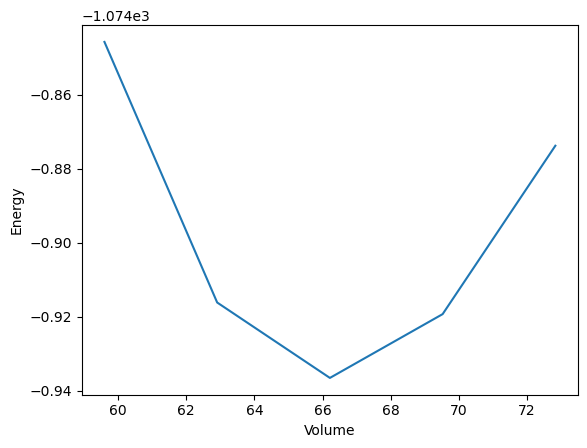

In [22]:
result = run_locally(flow)
result